<a href="https://colab.research.google.com/github/kanzaki-coder/deeplearning/blob/master/weed_VGG16_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

公開してあるグーグルドライブからファイルをダウンロードします

In [0]:
#グーグルドライブからファイルをダウンロードする方法
#ファイル限定

import requests

def download_file_from_google_drive(id, destination):

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)

    token = get_confirm_token(response)

    if token:

        params = { 'id' : id, 'confirm' : token }

        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):

    for key, value in response.cookies.items():

        if key.startswith('download_warning'):

            return value

    return None

def save_response_content(response, destination):

    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:

        for chunk in response.iter_content(CHUNK_SIZE):

            if chunk: # filter out keep-alive new chunks

                f.write(chunk)

#取得されるトークン
file_id = '1krNib7CAe5tqg895BEUvDoG1ujd2WB6q'

#欲しいフォルダ名
destination = 'cluster01.zip'

download_file_from_google_drive(file_id, destination)



VGG16というすでに訓練済みのモデルを途中まで利用してモデルを構築します

In [0]:

#ここからファインチューニング+VGG+水増し。ここから実行してOK（VGG16をダウンロード）
from keras import models
from keras import layers
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.applications import VGG16


input_size=224
#input_sizeは224,224までOK。デモ用に数字を150に落としてある。


vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(input_size,input_size, 3))
last = vgg_conv.output


vgg_conv.trainable = True

set_trainable = False
for layer in vgg_conv.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


mod = Flatten()(last)
mod = Dense(256, activation='relu')(mod)
#mod = Dropout(0.5)(mod)
preds = Dense(10, activation='softmax')(mod)

model = models.Model(vgg_conv.input, preds)

model.compile(optimizer=Adam(lr=1e-5),
              loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()
'''
参考URL
https://qiita.com/T_Tao/items/0e869e440067518b6b58#grad-cam%E3%81%AE%E5%AE%9F%E8%A3%85
'''

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

'\n参考URL\nhttps://qiita.com/T_Tao/items/0e869e440067518b6b58#grad-cam%E3%81%AE%E5%AE%9F%E8%A3%85\n'

解凍したファイルをそれぞれ訓練データと検証用のデータに分けます

In [0]:
import os 
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import keras.preprocessing.image as Image


#clsdir = "/content/deeplearning/weed_type"

clsdir = "/content/cluster01"



datagen = Image.ImageDataGenerator(
            featurewise_center = False,
            samplewise_center = False,
            featurewise_std_normalization = False,
            samplewise_std_normalization = False,
            zca_whitening = False,
            rotation_range = 90,
            width_shift_range = 0.3,
            height_shift_range = 0.3,
            horizontal_flip = True,
            vertical_flip = False,
            validation_split = 0.2,
            rescale=1./255
        )
#validation_splitでtrainとvalidationの比率を変更できる。


train_generator=datagen.flow_from_directory(
            clsdir,
            target_size=(input_size,input_size),
            batch_size=20,
            class_mode='categorical',
            shuffle=True,
            subset = "training"
        )

validation_generator = datagen.flow_from_directory(
            clsdir,
            target_size=(input_size,input_size),
            batch_size=20,
            class_mode='categorical',
            shuffle=True,
            subset = "validation"
        )

Found 9182 images belonging to 10 classes.
Found 2292 images belonging to 10 classes.


モデルを実行して画像を学習させていきます

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

#epochsを必要な長さに応じて変更

正解率と損失率をグラフ化します

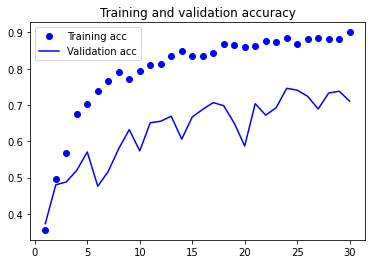

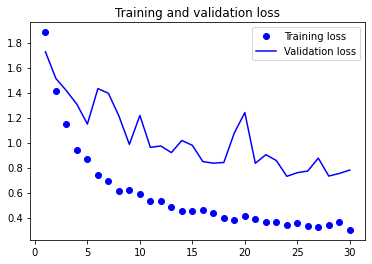

In [0]:
import matplotlib.pyplot as plt

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(acc)+1)

#正解率plot
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


#損失値をplot
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [0]:
#モデルを保存するなら⇒gradcamのための保存
model.save('weed_type.h1')
model.save_weights('weed_type.h5')
model.load_weights('weed_type.h5')

In [0]:
#20分類のclassを入力
classes=["hakidamegiku","hakidamegiku","hosoaogeitou","hosoaogeitou","ichibi",
         "ichibi","inubie","inubie","kosendangusa","kosendangusa","mameasagao",
         "mameasagao","mehishiba","mehishiba","ohishiba","ohishiba","oinutade",
         "oinutade","shiroza","shiroza"]

#20分類のclassを入力
classes=["hakidamegiku","hosoaogeitou","ichibi",
         "ichibi","inubie","kosendangusa","mameasagao",
         "mehishiba","ohishiba","oinutade","shiroza"]

では実際に画像をインプットして判別してみましょう

以下の画像を判定します


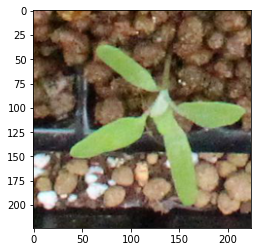

In [59]:

from PIL import Image
img_path = "/content/cluster01/shiroza/shiroza_IMG_1542_19.JPG"
#↑判定させたいpathを指定する

input_size=224

img = Image.open(img_path).convert('RGB') 
img = img.resize((input_size,input_size))
y = np.array(img, dtype=np.float32)
y = y / 255.
plt.imshow(y)
print("以下の画像を判定します")

この画像はshirozaです


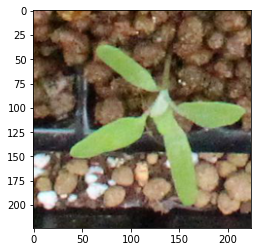

In [64]:
plt.imshow(y)
print("この画像は"+classes[pred_label]+"です")

どの部分の特徴をディープラーニングで認識しているか可視化してみましょう

In [0]:
# 好きな画像のパスを取得
img_path = "/content/cluster01/shiroza/shiroza_IMG_1542_19.JPG"

#ここからgradcam

from keras.preprocessing import image
from PIL import Image 
from keras.preprocessing import image as images

img=image.load_img(img_path,target_size=(input_size,input_size))

# データの前処理
img = image.load_img(img_path, target_size=(input_size,input_size))

# xは形状が(224,224,3)のfloat32型のnumpy配列
x = image.img_to_array(img)/255.0
# この配列サイズが(1,224,224, 3)のバッチに変換するために次元を追加
x = np.expand_dims(x, axis=0)



ディープラーニングの最後の層でより強く特徴量だと認識されている場所をプロットします


(14, 14)


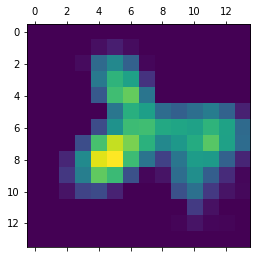

In [61]:
from keras import backend as K 
import matplotlib.pyplot as plt

# 予測ベクトル
output = my_model.output[:,np.argmax(preds[0])]

# 最後の層であるblock5_conv3の出力特徴マップ
last_conv_layer = my_model.get_layer(last_layer_name)

# block5_conv3の出力特徴マップでの「ある」クラス勾配
grads = K.gradients(output,last_conv_layer.output)[0]


# 各エントリは特定の特徴マップの平均強度
pooled_grads = K.mean(grads,axis=(0,1,2))

#出力マップの値にアクセスするための関数
iterate = K.function([my_model.input], [pooled_grads, last_conv_layer.output[0]])

# 2つの値をNumpy配列で取得
pooled_grads_value, conv_layer_output_value = iterate([x])

# 「ある」クラスに関する「このチャネルの重要度」を特徴マップ配列の各チャネルに掛ける
for i in range(pooled_grads_value.shape[0]):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]

# 最終的な特徴マップのチャネルごとの平均値がクラスの活性化のヒートマップ
heatmap = np.mean(conv_layer_output_value,axis=-1 )

# ヒートマップの後処理
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [62]:
import cv2

# cv2を使って画像読み込み
img = cv2.imread(img_path)
# 元画像と同じサイズになるようにヒートマップのサイズを変更
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# ヒートマップをRGBに変換
heatmap = np.uint8(255 * heatmap)
# ヒートマップをもとの画像に適応
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4はヒートマップの強度係数(もうちょっと強くしてもいい)
superimporsed_img = heatmap * 0.4 + img
# 画像を保存
cv2.imwrite('保存したい名前.jpg',superimporsed_img)

True

元の画像に重ねて表示

<function matplotlib.pyplot.show>

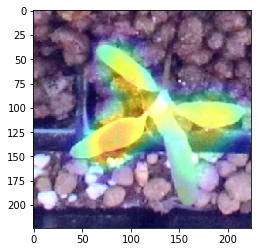

In [63]:
img = image.load_img('保存したい名前.jpg', target_size=(input_size,input_size))
img_tensor = image.img_to_array(img)
img_tensor /= 255.
plt.imshow(img_tensor)
plt.show

以上でデモンストレーションは終了です。

ここから下はrasnetの転移学習モデルになります

In [0]:
#ここからresnet50転移学習

from keras.applications import ResNet50

conv_base = ResNet50(weights='imagenet',
                     include_top=False,
                     input_shape=(224, 224, 3))

In [0]:
conv_base.summary()

In [0]:
#重みを凍結
conv_base.trainable = False
#モデル確認
from keras import models
from keras import layers
from keras.optimizers import Adam

model=models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu',input_dim=7*7*2048))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(20,activation='softmax'))


#最後のresblock(res5a_branch2aから最後まで)のみ再学習させる
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'res5a_branch2a':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# 更新される重みの数
print('after', len(model.trainable_weights))
#44ならOK
model.summary()

after 44
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_9 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dense_18 (Dense)             (None, 20)                5140      
Total params: 49,283,220
Trainable params: 40,671,508
Non-trainable params: 8,611,712
_________________________________________________________________


In [0]:
import os 
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import keras.preprocessing.image as Image


#clsdir = "/content/deeplearning/weed_type"

clsdir = "/content/drive/My Drive/cluster0312"



datagen = Image.ImageDataGenerator(
            featurewise_center = False,
            samplewise_center = False,
            featurewise_std_normalization = False,
            samplewise_std_normalization = False,
            zca_whitening = False,
            rotation_range = 90,
            width_shift_range = 0.3,
            height_shift_range = 0.3,
            horizontal_flip = True,
            vertical_flip = False,
            validation_split = 0.2,
            rescale=1./255
        )
#validation_splitでtrainとvalidationの比率を変更できる。


train_generator=datagen.flow_from_directory(
            clsdir,
            target_size=(input_size,input_size),
            batch_size=20,
            class_mode='categorical',
            shuffle=True,
            subset = "training"
        )

validation_generator = datagen.flow_from_directory(
            clsdir,
            target_size=(input_size,input_size),
            batch_size=20,
            class_mode='categorical',
            shuffle=True,
            subset = "validation"
        )

Found 3129 images belonging to 20 classes.
Found 775 images belonging to 20 classes.


In [0]:
#モデルのコンパイル
model.compile(optimizer=Adam(lr=1e-5),
              loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()


In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50)

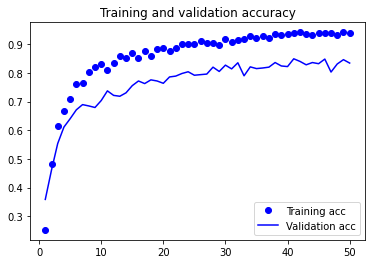

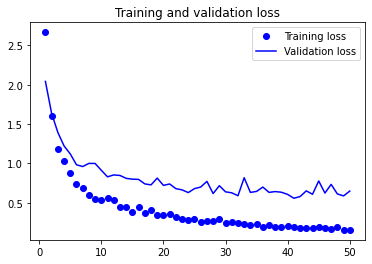

In [0]:
import matplotlib.pyplot as plt

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(acc)+1)

#正解率plot
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


#損失値をplot
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
